<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## 4.05 - Generalized Linear Models

_Authors: Matt Brems (DC) h/t Timothy Book, Justin Pounders (ATL)_

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

/Users/jmpounders/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Generalized Linear Models (GLMs)

**Generalized linear models** describes a class of models that take the linear model (think linear regression) and generalizes the linear model beyond the assumptions of the linear regression model we discussed last week.

In fact, you have already seen an example of a _generalized_ linear model: logistic regression.

**Linear regression:**

$$\hat{y} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p $$

> The predicted variable $\hat{y}$ will be in the range $(-\infty, \infty)$.

**Logistic regression:**

$$ \hat{y} = \sigma\left(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p\right) $$

where

$$ \sigma(t) = \frac{e^t}{1 + e^t} $$

> The predicted variable $\hat{y}$ is now in the range $(0, 1)$.

---

> **What are examples of things we might predict that don't fall in the range $(-\infty, \infty)$ or $(0,1)$?

- ACT scores: {0, 1, 2, ..., 36}
- Stock price: (0, \infty)
- Lifetime of a manufactured component: [0, \infty)

### Bend the spoon...

Generalized linear models are _linear in the coefficients_ but "bend" the linear estimator to match the range we want for our target, $Y$.

Three ingredients:
- The linear piece
- The "bending" function
- A probability distribution for errors

$$ Y = g\left( \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p \right) + \varepsilon $$

- $\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p$ is the linear piece
- $g(\cdot)$ is the bending piece; called a link function
- $\varepsilon$ is the random "error" piece

---

**Linear regression:**

- Linear piece: $\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p$
- Link function: $g(t) = t$
- Error component: $\varepsilon \sim N(0,\sigma)$

![](../images/lin_reg.png)

**Logistic regression:**

- Linear piece: $\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p$
- Link function: $g(t) = \frac{e^t}{1 + e^t}$
- Error component: $\varepsilon \sim Bernoulli(p)$

![](../images/log_reg.png)

### Choices, choices, choices...

Chosing the right kind of generalized linear model (GLM) from all possibilities really boils down to picking the "error."

The "error" model is really telling you how you expect observations to be distributed.  It is a probability distribution.

> 1. In traditional linear regression, the error term is a normal distribution.  This means that you expect actual observations to be normally distributed around your line.

> 2. In logistic regression, the error term is a Bernoulli distribution.  This means that you expect actual observations to be above (1) or below (0) the logit curve with a certain probability.

Choosing the distribution function often points to a link function you should use: [here is a table](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function).

Examples:

1. If $Y$ is a non-negative integer:
   - Poisson regression if mean $\approx$ variance
   - Negative Binomial regression if variance $\gg$ mean (overdisperse)
   - For example,
     - Units sold
     - Customers through the door
     - Patients to the ER
     - Number of cars racing the red light
2. If $Y$ values represent categories
   - Multinomial logistic regression (unordered categories)
   - Ordinal logstic regression (ordered categories)
   - For example,
     - Does a population tend to buy groceries at Whole Foods, Publix or Kroger?
     - Will millenials vote democrat, republican or independent?
     - Predicting the Amazon star rating of books.
3. If $Y$ values are continuous, non-negative
   - Gamma regression
   - For example,
     - How long before my Uber/Lyft gets here?
     - Home prices

## The `statsmodels` API

We will use the `statsmodels` API to explore GLMs in Python.  (`sklearn` does not have a robust implementation for GLMs.)  Documentation and examples for `statsmodels` can be found [here](http://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM).

## Logistic Regression

**When do we use it?** When we want to model something on the $\{0,1\}$ range... like the probability that a person will develop a disease.

> Is logistic regression actually _regression_ or _classification_???

### The Data
The data used from this example come from one of UCLA's IDRE modules (for R).  The module can be found [here](https://stats.idre.ucla.edu/r/dae/logit-regression/).

**Data Description:** _A researcher is interested in how variables, such as GRE (Graduate Record Exam scores), GPA (grade point average) and prestige of the undergraduate institution, effect admission into graduate school. The response variable, admit/don’t admit, is a binary variable._

In [3]:
grad = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

# Let's do some EDA!
print(grad.shape)
grad.head()

(400, 4)


,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [4]:
grad.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


In [6]:
grad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


In [7]:
grad.admit.value_counts()

0    273
1    127
Name: admit, dtype: int64

/Users/jmpounders/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x113248860>,
      dtype=object)

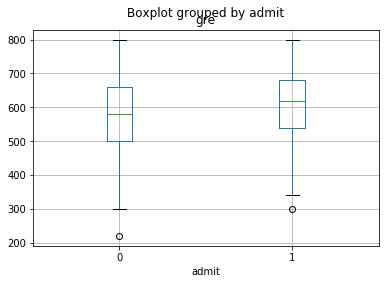

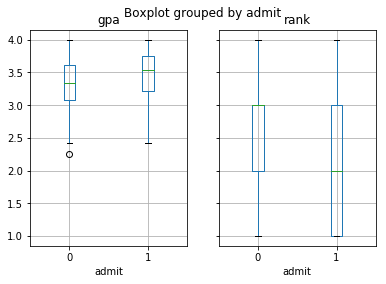

In [8]:
grad.boxplot('gre', by='admit')
grad.boxplot(['gpa', 'rank'], by='admit')

**Model time...**

In [19]:
# Now, let's build our GLM
indep_vars = ['gre', 'gpa', 'rank']
X = sm.add_constant(grad[indep_vars])
y = grad.admit

glm_logit = sm.GLM(y, 
                   X,
                   sm.families.Binomial(sm.families.links.logit))
results_logit = glm_logit.fit()

In [20]:
results_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      396
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -229.72
Date:                Mon, 14 May 2018   Deviance:                       459.44
Time:                        14:11:44   Pearson chi2:                     399.
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4495      1.133     -3.045      0.002      -5.670      -1.229
gre            0.0023      0.001      2.101      0.036       0.000       0.004
gpa            0.7770      0.327      2.373      0.018       0.135       1.419
rank          -0.5600      0.127     -4.405      0.000      -0.809      -0.311
==============================================================================
"""

**Check:** How would I interpret the coefficient for `rank`?

In [31]:
np.exp(-0.5600)

0.5712090638488149

**Interpretation:** As the rank of my undergraduate institution increases by 1, my odds of being admitted drop by a factor of 0.57.

**Check:** If I scored 100 points better on my GRE, how would that affect my odds of acceptance?

In [9]:
math.exp(100*0.0023)

1.2586000099294778

**Interpretation:** As my GRE score increases by 100 points, my odds of being admitted go up by 26%.

**Note:**
- GLMs are typically not "directly solvable."  Instead, a solution is initially guessed then iteratively refined until to you converge on an answer.
- The default maximum number of iterations for GLMs is 100. If `No. Iterations` is 100, that means the algorithm probably didn't converge and that the $\mathbf{\hat{\beta}}$ are still changing. Therefore, **your output is unreliable - DO NOT USE IT**.

## Poisson Regression

**When do we use it?** When we want to model something on the $\{0,1,2,\ldots\}$ range... like number of objects sold or nunber of awards earned!

#### Data
We'll again rely on UCLA's IDRE module.  This one can be found [here](https://stats.idre.ucla.edu/r/dae/poisson-regression/).

#### Data Description
_The number of awards earned by students at one high school. Predictors of the number of awards earned include the type of program in which the student was enrolled (e.g., vocational, general or academic) and the score on their final exam in math._

In [23]:
award = pd.read_csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")

# Let's do some EDA:
award.head()

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40


/Users/jmpounders/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


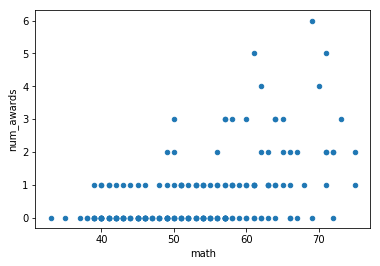

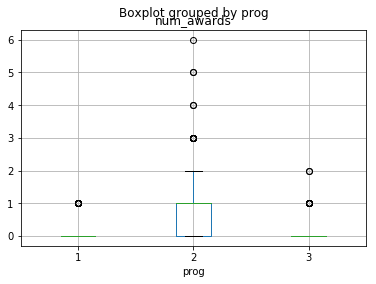

In [24]:
award.plot('math', 'num_awards', kind = 'scatter')
award.boxplot('num_awards', by = 'prog')

In [26]:
# Notice that prog is actually a categorical variable - I am aware of this.
# I'm going to suspsend that knowledge for the sake of example.
poi_vars = ['prog', 'math']
x_poi = sm.add_constant(award[poi_vars])
y_poi = award.num_awards

glm_poi = sm.GLM(y_poi,
                 x_poi,
                 family = sm.families.Poisson()).fit()
glm_poi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             num_awards   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -189.75
Date:                Mon, 14 May 2018   Deviance:                       203.45
Time:                        14:14:49   Pearson chi2:                     227.
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5781      0.677     -8.242      0.000      -6.905      -4.252
prog           0.1233      0.163      0.755      0.450      -0.197       0.443
math           0.0861      0.010      8.984      0.000       0.067       0.105
==============================================================================
"""

**Interpretation**: For a one-unit increase in `math`, I expect to win $e^{0.0861} \approx 1.09$ times as many awards.

In [27]:
math.exp(0.0861)

1.0899153143871725

## Gamma Regression

**When do we use it?** When we want to model something on the $[0,\infty)$ range... like time until some event occurs!

### The Data
The data used from this example come from a 1945 study about and is inspired by [Peter Craigmile's use](http://www.craigmile.com/peter/teaching/7430/notes/7_gamma_influence.pdf) of this example.

**Data Description:** _“Hurn, et al. (1945) published data on the clotting time of blood, giving clotting time in seconds for normal plasma diluted to nine different percentage concentrations with prothrombin-free plasma; clotting was induced by two lots of thromboplastin.” [McCullagh and Nelder](http://www.utstat.toronto.edu/~brunner/oldclass/2201s11/readings/glmbook.pdf)_

In [33]:
clot = pd.read_csv("../clotting.csv", index_col = "index")

In [34]:
clot.head()

,plasma_pct,clot_time,lot
index,,,
1,5,118,1
2,10,58,1
3,15,42,1
4,20,35,1
5,30,27,1


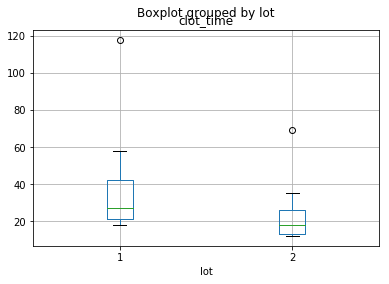

In [35]:
clot.boxplot('clot_time', by = 'lot')

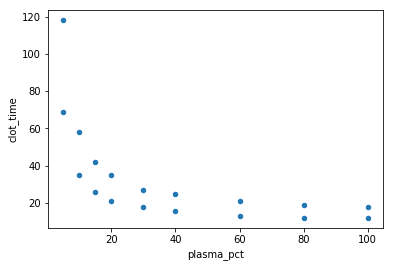

In [36]:
clot.plot('plasma_pct', 'clot_time', kind = 'scatter')

In [37]:
clot['plasma_pct_log10'] = np.log10(clot['plasma_pct'])

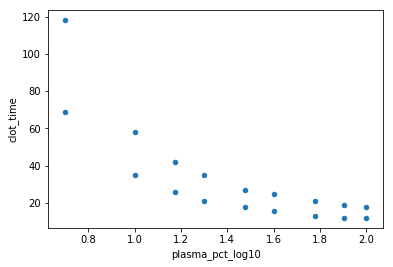

In [38]:
clot.plot('plasma_pct_log10', 'clot_time', kind = 'scatter')

In [39]:
clot['interaction'] = clot['plasma_pct_log10'] * clot['lot']

In [42]:
y = clot['clot_time']
X = sm.add_constant(clot[['plasma_pct_log10','lot','interaction']])

results = sm.GLM(y,
                 X,
                 family = sm.families.Gamma()).fit()
results.summary()

/Users/jmpounders/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:244: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:              clot_time   No. Observations:                     18
Model:                            GLM   Df Residuals:                         14
Model Family:                   Gamma   Df Model:                              3
Link Function:          inverse_power   Scale:              0.002129691535969636
Method:                          IRLS   Log-Likelihood:                  -26.889
Date:                Mon, 14 May 2018   Deviance:                       0.029401
Time:                        15:40:38   Pearson chi2:                     0.0298
No. Iterations:                     5                                           
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0092      0.002     -4.089      0.000      -0.014      -0.005
plasma_pct_log10     0.0163      0.002      7.121      0.000       0.012       0.021
lot                 -0.0074      0.002     -4.383      0.000      -0.011      -0.004
interaction          0.0190      0.002     11.229      0.000       0.016       0.022
====================================================================================
"""

In [43]:
results_log = sm.GLM(y,
                     X,
                     family = sm.families.Gamma(link = sm.families.links.log)).fit()
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:              clot_time   No. Observations:                     18
Model:                            GLM   Df Residuals:                         14
Model Family:                   Gamma   Df Model:                              3
Link Function:                    log   Scale:              0.023752798029904407
Method:                          IRLS   Log-Likelihood:                  -48.371
Date:                Mon, 14 May 2018   Deviance:                        0.31576
Time:                        15:41:15   Pearson chi2:                      0.333
No. Iterations:                     6                                           
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.0877      0.420     14.486      0.000       5.264       6.911
plasma_pct_log10    -1.4654      0.281     -5.211      0.000      -2.017      -0.914
lot                 -0.5845      0.266     -2.199      0.028      -1.105      -0.064
interaction          0.0794      0.178      0.446      0.655      -0.269       0.428
====================================================================================
"""

**Interpretation**: For a one-unit increase in `plasma_pct_log10`, I expect the blood will take $e^{-1.4654} \approx 23\%$ as much time to clot.

In [28]:
math.exp(-1.4654)

0.230985578764514

## Analysis of Deviance (BONUS)

We've spoken briefly about deviance before as a generalization of the sums of squares of error for generalized linear models.

Suppose we have two models:

$$
\begin{eqnarray*}
Y_{full} &=& \beta_0 + \beta_1X_1 + \cdots + \beta_kX_k + \cdots + \beta_pX_p + \varepsilon \\
Y_{reduced} &=& \beta_0 + \beta_1X_1 + \cdots + \beta_kX_k + \varepsilon
\end{eqnarray*}
$$

We say that $Y_{reduced}$ is nested in $Y_{full}$, because the reduced model could "fit inside" the full. (You can learn more about nested linear regression models [here](http://people.reed.edu/~jones/Courses/P24.pdf), although the ideas approximately hold for generalized linear models as well.)

When we have one model nested inside the other, there is a statistical test to see if adding new variables are worth it. (Think about it like looking at the difference in mean squared error or $R^2$ by adding a variable, but getting a $p$-value quantifying whether or not it's worth it!)

We calculate the **deviance** of the reduced model and subtract the **deviance** of the full model from it. This difference in deviance follows a [chi-squared distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution) with $p-k$ degrees of freedom. (Note that $p-k$ indicates how many variables we took out of our full model to get to the reduced model!)

**This comparison only works with nested models! Do not use if your models are not nested!**

In [30]:
# Test model differences
from scipy.stats import chi2

# First, build our top model
indep_vars = ['gre', 'gpa', 'rank']
X = sm.add_constant(grad[indep_vars])
y = grad.admit

glm_logit = sm.GLM(y, 
                   X,
                   sm.families.Binomial(sm.families.links.logit))
results_logit = glm_logit.fit()


# Next, let's see if we can safely reduce our model
reduced_vars = ['gre', 'gpa']
X_reduced = sm.add_constant(grad[reduced_vars])

results_reduced = sm.GLM(y,
                 X_reduced,
                 sm.families.Binomial(sm.families.links.logit)).fit()
results_reduced.summary()


# Calculate the difference in deviance
D = results_reduced.deviance - results_logit.deviance
print('Difference in Deviance: ', D)

# Check to see if this difference is significant
pval = 1 - chi2.cdf(D, df = 1)
print('p-value of test of difference: ', pval) # What can we conclude here?

Difference in Deviance:  20.902216653552784
p-value of test of difference:  4.833349600774639e-06


$H_0:$ reduced model is better

$H_A:$ reduced model is not better

Because $p < \alpha$, we reject $H_0$ and conclude that the reduced model is not better.